<a href="https://colab.research.google.com/github/rblue36/Sneaker-Classifier/blob/main/Jordan_Sneaker_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jordan Sneaker Classifier

The classifier has 3 classes:


*   Nike Jordan 1
*   Nike Jordan 4
*   Nike Jordan 11





In [1]:
# import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available. Training on CPU.')
else:
  print('CUDA is available. Training on GPU.')

CUDA is available. Training on GPU.


In [2]:
# imshow function for displaying images
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [3]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# unzip dataset folder 
!unzip '/content/gdrive/MyDrive/sneakerDataset.zip' > /dev/null

replace sneakerDataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [3]:
# dataset directory
data_dir = 'sneakerDataset'

# define batch size
batch_size = 32

# define transforms
# training (with random flips and rotation)
train_transform = transforms.Compose([transforms.Resize(224), # resize to 224x?
                                transforms.CenterCrop(224), # take a square (224x224) crop from the centre
                                transforms.RandomHorizontalFlip(), # randomly flip on horizontal axis
                                transforms.RandomRotation(10), # random rotation
                                transforms.ToTensor(), # convert data to torch.FloatTensor
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])]) # normalise for each colour channel

# validation and testing
transform = transforms.Compose([transforms.Resize(224), # resize to 224x?
                                transforms.CenterCrop(224), # take a square (224x224) crop from the centre
                                transforms.ToTensor(), # convert data to torch.FloatTensor
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])]) # normalise for each colour channel

# choose the training, validation and test datasets
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transform)
val_data = datasets.ImageFolder(data_dir + '/val', transform=transform)
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)

# prepare the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

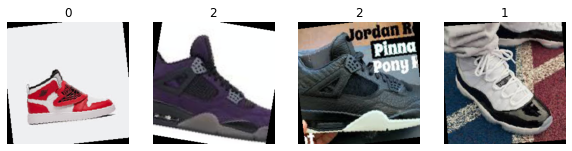

In [4]:
# obtain one batch of training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# plot the first 4 images in the batch, along with the corresponding labels
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)
    ax.set_title(str(labels[ii].item())) 


In [5]:
#########################################################################
# use a ResNet18 network
#########################################################################
# NB This network requires an image input size of 3x224x224 and normalised using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

import torch.nn as nn
import torchvision.models as models

# load a pre-trained ResNet network with 18 layers
model = models.resnet18(pretrained=True)

# # get the number of inputs for the final layer (fc) of the network
num_ftrs = model.fc.in_features
# # replace the final layer so that the output is three classes
model.fc = nn.Linear(num_ftrs, 3)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()



In [6]:
import torch.optim as optim

# specify loss function (cross entropy loss)
criterion = nn.CrossEntropyLoss()

# specify optimizer (Adam optimiser) and learning rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [7]:
# number of epochs to train the model
n_epochs = 20

# initialise tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

# create empty lists to store the training and validation losses
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in val_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)

    # store the training and validation losses for later visualisation
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'jordan_sneaker_model_resnet18.pt') # save in colab
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/jordan_sneaker_model_resnet18.pt') # save in google drive
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.708672 	Validation Loss: 0.336013
Validation loss decreased (inf --> 0.336013).  Saving model ...
Epoch: 2 	Training Loss: 0.165914 	Validation Loss: 0.121603
Validation loss decreased (0.336013 --> 0.121603).  Saving model ...
Epoch: 3 	Training Loss: 0.067691 	Validation Loss: 0.102754
Validation loss decreased (0.121603 --> 0.102754).  Saving model ...
Epoch: 4 	Training Loss: 0.038962 	Validation Loss: 0.091796
Validation loss decreased (0.102754 --> 0.091796).  Saving model ...
Epoch: 5 	Training Loss: 0.022886 	Validation Loss: 0.094051
Epoch: 6 	Training Loss: 0.014141 	Validation Loss: 0.082642
Validation loss decreased (0.091796 --> 0.082642).  Saving model ...
Epoch: 7 	Training Loss: 0.013428 	Validation Loss: 0.071888
Validation loss decreased (0.082642 --> 0.071888).  Saving model ...
Epoch: 8 	Training Loss: 0.006810 	Validation Loss: 0.079391
Epoch: 9 	Training Loss: 0.007449 	Validation Loss: 0.089776
Epoch: 10 	Training Loss: 0.006167 	Valida

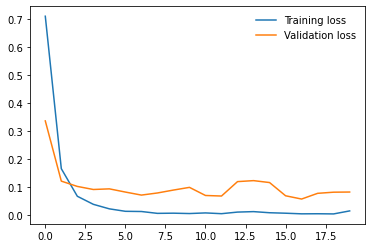

In [8]:
# visualise the training and validation losses over time
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

In [9]:
# Load the Model with the Lowest Validation Loss
model.load_state_dict(torch.load('jordan_sneaker_model_resnet18.pt'))

<All keys matched successfully>

In [10]:
# Test the Trained Network

# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(3): # for each class
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.014924

Test Accuracy of     0: 100% (43/43)
Test Accuracy of     1: 100% (34/34)
Test Accuracy of     2: 100% (35/35)

Test Accuracy (Overall): 100% (112/112)


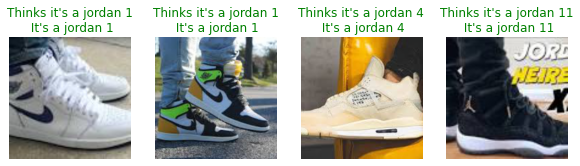

In [11]:
# Visualize Sample Test Results

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the first 4 images in the batch, along with the corresponding labels
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    if preds[ii].item() == 0 :
        predsvalue = "jordan 1"
    elif preds[ii].item() == 1 :
        predsvalue = "jordan 11"
    elif preds[ii].item() == 2 :
        predsvalue = "jordan 4"    
        
    if labels[ii].item() == 0 :
        labelvalue = "jordan 1"
    elif labels[ii].item() == 1 :
        labelvalue = "jordan 11"
    elif labels[ii].item() == 2 :
        labelvalue = "jordan 4"    
    imshow(images.cpu()[ii], ax=ax, normalize=True)
    ax.set_title("{}\n {}".format(("Thinks it's a "+predsvalue), ("It's a "+labelvalue)),
                 color=("green" if preds[ii]==labels[ii] else "red")) 